In [1]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
# Model
import impl.layer as l

class LSTM:
    
    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters wights and biases
        Z = H + D
        m = dict(
            Wf=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wi=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wc=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wo=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bf=np.zeros((1, H)),
            bi=np.zeros((1, H)),
            bc=np.zeros((1, H)),
            bo=np.zeros((1, H)),
            by=np.zeros((1, D)))

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return (np.zeros((1, self.H)), np.zeros((1, self.H)))

    # P_dropout == keep_prob in this case!
    # q = keep_prob and p_dropout = p ???
    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        #         q = 1-p_dropout
        #         u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX

    def forward(self, X, h, m, train):
        Wf, Wi, Wc, Wo, Wy = m['Wf'], m['Wi'], m['Wc'], m['Wo'], m['Wy']
        bf, bi, bc, bo, by = m['bf'], m['bi'], m['bc'], m['bo'], m['by']

        h_old, c_old = h
        X_one_hot = X.copy()

        X = np.column_stack((h_old, X_one_hot))

        hf, hf_cache = l.fc_forward(X, Wf, bf)
        hf, hf_sigm_cache = l.sigmoid_forward(hf)

        hi, hi_cache = l.fc_forward(X, Wi, bi)
        hi, hi_sigm_cache = l.sigmoid_forward(hi)

        ho, ho_cache = l.fc_forward(X, Wo, bo)
        ho, ho_sigm_cache = l.sigmoid_forward(ho)

        hc, hc_cache = l.fc_forward(X, Wc, bc)
        hc, hc_tanh_cache = l.tanh_forward(hc)

        c = hf * c_old + hi * hc
        c, c_tanh_cache = l.tanh_forward(c)

        h = ho * c
        h_ = (h, c)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        if train:
            y, do_cache = self.dropout_forward(X=y, p_dropout=self.p_dropout)
            cache = (X, hf, hi, ho, hc, hf_cache, hf_sigm_cache, hi_cache, hi_sigm_cache, ho_cache, 
                     ho_sigm_cache, hc_cache, hc_tanh_cache, c_old, c, c_tanh_cache, y_cache, do_cache)
        else: # train=False
            cache = (X, hf, hi, ho, hc, hf_cache, hf_sigm_cache, hi_cache, hi_sigm_cache, ho_cache, 
                     ho_sigm_cache, hc_cache, hc_tanh_cache, c_old, c, c_tanh_cache, y_cache)

        return y, h_, cache

    def backward(self, dy, dh, cache, train):
        if train:
            X, hf, hi, ho, hc, hf_cache, hf_sigm_cache, hi_cache, hi_sigm_cache, ho_cache, ho_sigm_cache, hc_cache, hc_tanh_cache, c_old, c, c_tanh_cache, y_cache, do_cache = cache
            dy = self.dropout_backward(dout=dy, cache=do_cache)
        else:
            X, hf, hi, ho, hc, hf_cache, hf_sigm_cache, hi_cache, hi_sigm_cache, ho_cache, ho_sigm_cache, hc_cache, hc_tanh_cache, c_old, c, c_tanh_cache, y_cache = cache

        dh_next, dc_next = dh

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next

        dho = c * dh
        dho = l.sigmoid_backward(dho, ho_sigm_cache)

        dc = ho * dh
        dc = l.tanh_backward(dc, c_tanh_cache)
        dc = dc + dc_next

        dhf = c_old * dc
        dhf = l.sigmoid_backward(dhf, hf_sigm_cache)

        dhi = hc * dc
        dhi = l.sigmoid_backward(dhi, hi_sigm_cache)

        dhc = hi * dc
        dhc = l.tanh_backward(dhc, hc_tanh_cache)

        dXo, dWo, dbo = l.fc_backward(dho, ho_cache)
        dXc, dWc, dbc = l.fc_backward(dhc, hc_cache)
        dXi, dWi, dbi = l.fc_backward(dhi, hi_cache)
        dXf, dWf, dbf = l.fc_backward(dhf, hf_cache)

        dX = dXo + dXc + dXi + dXf
        dh_next = dX[:, :self.H]
        dc_next = hf * dc

        dX = dX[:, self.H:]
        dh = (dh_next, dc_next)

        grad = dict(Wf=dWf, Wi=dWi, Wc=dWc, Wo=dWo, Wy=dWy, bf=dbf, bi=dbi, bc=dbc, bo=dbo, by=dby)

        return dX, dh, grad
            
    def train_forward(self, X_train, h_):
        ys, caches = [], []
        #         h_init = h.copy()
        h, c = h_
        h_init = (h.copy(), c.copy())
        h = []
        for _ in range(self.L):
            h.append(h_init)
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(y, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss # + reg_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append((np.zeros((1, self.H)), np.zeros((1, self.H))))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t], train=True)
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                
        return dX, grads
    
    def test(self, X_seed, h_, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        #         h_init = h.copy()
        h, c = h_
        h_init = (h.copy(), c.copy())
        h = []
        for _ in range(self.L):
            h.append(h_init)

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(y, h[layer], self.model[layer], train=False)
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
#     for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    eps = 1e-8 # const epsillon
    smooth_loss = 1
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    # Epochs
    for iter in range(1, n_iter + 1):

        # No batches or only one
        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Updating the model parameters
            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items, dict={}
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
                
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=100) # time_step=mb_size
            print(sample)
    
    return nn

Iter-10 loss: 106.3546
e;WD – e.oe adhsT f biemleenunse nannrntyisl ic. 'urb nhoo o7ao"Cd s dpildehaao c pi hl anhliea o dia
Iter-20 loss: 109.6803
epEProhS nd iyg nii hoc -of  3yoecoe hhe ziiExnrn8bc Lo rhonb5eolan bhome idaah.Stnta noSoantverr,t w
Iter-30 loss: 106.2750
e;j1f6tWeyaC taado,i ieapsfonrhdrend   reo uih el tt2ittrr2o f hcopEhD teeryhcorgahastaenpiandarnid  
Iter-40 loss: 104.5462
eW.JaLtm9etirtrm idwaahehre r)iuhrldle"nwfrirasc on htead nahhd ietphiaa ntrei C h-eatseplrhm,6n erCe
Iter-50 loss: 108.9700
e6W' l SiSs lt aodsa.oAn8ay eida.efdhuaaer risrurwhSs tfcatmlrckilrh   aoaorNi hior aoe arDh e,wSe  d
Iter-60 loss: 105.6447
eehh:Seg,i J, ulfgnmeapensIt uJ,iuy ittulrno.aGio ui  Goednsoai  cvog  wo rasAn'ceftrEah esluh hp本g i
Iter-70 loss: 102.7725
eU faoce  ehei e.yturtthhadensta0Wacttbo Girkar tnKalnrSteihnJ aaeelEeconisltdad iotn5newhru e foop n
Iter-80 loss: 100.7437
eucasernidnB  Ileitd cok coobteeo fh anateot endhs5istwauanar atnyss.untIren iglaea m m npstfAe(Wn re


Iter-670 loss: 97.0444
eRlE8tpoo korapan utumgten onr rnilein tarditsh cit. Em, fesneastmmrinit.iton. ppheaod,azi,ast ttos t
Iter-680 loss: 98.7486
es-Pkuaureliaoadsaan itazie ilmohaniluinarm rhesrgtndU eurt ,s yfs axp goh theoa andikc etl le4ulier 
Iter-690 loss: 94.7891
eyxwov liod tpun fegyeai tothise  aI 1a9,rs tnthi.'as ,wuegtotthe.ilaedpmioiree topangtes neitsotddda
Iter-700 loss: 93.9695
ebets mearohn h5.esurana rmhie stN , phhe Aneh mog 8ts rrotsftor xtei ah apetNmd ldaTiys fgir, iae cn
Iter-710 loss: 92.3880
e pa日ied hiaoun .whGpresd ffrud laridthe miiSthin uthy epocGcyflbcteg itiap eondJoiss d oarrlourdd gn
Iter-720 loss: 98.5979
emJ%d Byil. ar le  to-and ow r.n tethetiif fitnd it reas Itre otC renvb'trcaro aNun hgh man ee Dg tan
Iter-730 loss: 99.8371
e25uln opon 96thxehe te ieo cty  ko9 gsd ated anlnd Fip 5 fAIy thl l.gskoh oedd ftlan torotun pafss c
Iter-740 loss: 97.6345
eOith4fxndgAbitl6e tngJgurf5nogthainc Ltopnrosh iarl odard fc sh euntioc tppilitijfan2e bioig othoo t


Iter-1330 loss: 91.7385
e35 Epslaly o laoimiteomy ai bG
 ie  n o3 ie r fi .elo'ogapoan mob anhe iohe ioac Ssisanyi ahe miioff
Iter-1340 loss: 91.4604
e meanto trypcrosjrciocdireRloyrundecfac ti therctitantaeperitlnhaelte oagby a bre Jinleen arlif Asr,
Iter-1350 loss: 95.2834
erl nocorWeros ck7nxfTd utca6ettt cawx  aa8anoailopl Eed  ea ngi5D n 5lfh  steoyh lel,n rlamnet 4ersf
Iter-1360 loss: 93.3618
eh inri tthiuors xfkrin praHreeithu Wre krvps s oerisii.ef  bocapfieasanmawoCt iv bn he st yw Esstme 
Iter-1370 loss: 90.9645
e% Sase o3eotxndvx9sotlleloa  ets8ry cptfaneor fcol amTsnh Pscto . irudCM,"rclireeyWhihe rpwlrthe td 
Iter-1380 loss: 93.4803
ean prSWre ooswop 1rot Jtpeme tafdetd eisi ohigoj ired olnarn i  uronelvo, orJeeecw th tPgandvig hh n
Iter-1390 loss: 91.3391
eing irD Hentho aeorrgmuthit uiSete Sithletuorav gnh8 anlasxeirearw: ,isndlonio s1 3uoh'itbySe isnutu
Iter-1400 loss: 92.6653
et
.y inanloo tn A–crs5d tcowovuimand yrlinitehe lketb sanIe ifwen ceili ipSowtshiy  Japn
hd o

Iter-1990 loss: 88.5802
ed A3pan0mabe.orfa e ee 2aflis oteoosis tf th oR  oome dEy tr lanliwra. Wlytr1dEttofge c, truutags pt
Iter-2000 loss: 86.8955
eCNand bhe eom nrgas ci2eOilofoo amd u ndonf Wantkoae irt opf miins fs y w eslay wh tan yd lJWey anCa
Iter-2010 loss: 86.4640
ed3tpantyi hi wrarl tnhi te ate aon, t itnda  fitvgeeke itfEegretNMptwas d Wadicstcjlava, ,  Ereohy w
Iter-2020 loss: 84.1189
eWc an onn 1aihekacg ourt. Jhte fmaedIghwh a"pctJef uAhean.ibemos Tn Waee d puro,yclohr toigUyhefoan 
Iter-2030 loss: 88.0851
e.% andedlanksttpal miucn wsminarrys aneinc thhel pendes ans iar-npy ye c d pip whg lisomIniiiFeno h.
Iter-2040 loss: 84.3643
ejvetihe reuroinl trlod poeEy ux Wiin;d "bade aos kapar Jarsds lammin7 D e uh6lotirem mxtt p pal unos
Iter-2050 loss: 88.4553
er"n' wapamssgi0in fohat eoleetNe,ib iteoa-u nd 'g ri rhe y. p ieo,o ime NAnDean  alooge hnunterw oth
Iter-2060 loss: 86.4453
e o0n tl-y Wint an ase Peleee dBathe tc9 amni4d  . aWti acpthhe letnspai ecan,ool xdeu"td apen

Iter-2650 loss: 84.5531
ey wwThe aeo chbre waptanrtleoos artiglcdantWobkw. 0s' ad it oahoa otsote fly esosdNr nwrdt ratnd nd 
Iter-2660 loss: 81.4388
e,.r  paparry.sdOsvrs Jamg  meool Sfrl thit Hcnheo.o od1d wo agth Jarucoobarolalre1 n eninamk; wcOIin
Iter-2670 loss: 82.7163
e–jxErvpremctand masf N manjt tteeoOcp;2OEmrwaIhe the ia md csers paslilehyi ret o2Ieds pspond wieoer
Iter-2680 loss: 85.7414
es, cithiirnse rd  fstocmou lefire se aw8 ola7an d 5oW vRonos teinake ol1Parge Seaiteiitre Iree Jalg 
Iter-2690 loss: 83.7527
eLom nkioNs d ids Oohur ted phehd leesl ed mWaurn, p n9nEpy Ce  th arestWp aned thin aoksty xeO8, ean
Iter-2700 loss: 81.5415
eD2cosr Wore slyeoAd Wreh6 lapn.rot dorliodcatlirgapcuna aslei iore ing , Ifod isesf,-tesrh7s  Haan u
Iter-2710 loss: 80.7232
eJhiruntoustU vmn,sn anmHotopsr mf'ritcololan t rnishe bhe tAooig ptf1) ini aoend solg6amt u2on,eg is
Iter-2720 loss: 82.6945
e woStryy  athh Jpn icit athe Tomw epeit  urrn xf5heabsliscreigvepsbNan lewipouIhoungNtiopoy.d

Iter-3310 loss: 79.6425
e-lapand Jesl susutei apof nioP theox rfrb obarand Sdulas wmanda srt oSesttcpeeNokunfeUecg lChe 4umeo
Iter-3320 loss: 76.9885
edm theuntorcdeomnuh Joi"anhaireitxin"Nembrt rionWwd  9ints izAapoaboko rlaong wh Tf oonoK N6sdei tio
Iter-3330 loss: 85.9094
eEJyapeshevseuoc RoplJeJanoms. iart eary. 1thaentd s, Aitl tCheantg sutm oh Wakaapel and uapinof hioo
Iter-3340 loss: 88.2351
et  Jappoinesy oin kt eoas olamlot f at toNo dh rcys te rnhekgedoo Dllan hr-sartargNTarta the watihyu
Iter-3350 loss: 80.4883
etAy Jpaanecamse'f Ex6en win thity 38enWos  are an'nnd an ac W tf0T ind datol-aoin Ufinontsy ry caist
Iter-3360 loss: 81.0508
eo, fhepon thal  Easn. a"an d –f sng d anefipatrn tsh,desins t-hothhas thucliteir wedi iy mIhteth is,
Iter-3370 loss: 87.7435
eeat lanthe eacue. war awoooan mo
. wcitee1Rtrmarpjmeer-nomov. iy'he rirpG paleundirla;esr aRthsi-me 
Iter-3380 loss: 78.7131
eLO"f, st pofofara5a al anhemahen ktsthth8aNeloris  rJanlalhitgius w,et he ax ard in Pd toan o

Iter-3970 loss: 82.6718
e the Canseoloniromrarke esarDe–0日Ta9p stheihyd ird 1n prun 'cd th  maf n6ley'e the Jtmroltalde,'hir 
Iter-3980 loss: 79.4599
eend Tirotd fx, alhs hesd Jathathe wNattomreorerd n iwvee tois san.d th, ifitistye bit Nne 41.ttheece
Iter-3990 loss: 78.7812
eroy Jaulsnmrd oufoverl"sSeted –20urin the i wteacsthbritht argot im2n tal ins re mteigtg2 xI 2ntbm t
Iter-4000 loss: 79.0376
e-Ffestrl theronit pa. JCJafoeeganstithresn pkan9r7ed isleteasgyeGlaigxpeito wa dlamcte.. e cusEithy 
Iter-4010 loss: 80.8685
ePap ooliathomantno hoy frtoesrlartt entitrpnso; we8 Ndslyas mily cvindommt r9uroneTI d ouearf edoung
Iter-4020 loss: 82.3058
ed sbean clam  eatst bhhan emes1 thHa Notlin wolmfstst iig m andd ofhst an. af o te Il,canod  Erung R
Iter-4030 loss: 85.0865
efTy he cnoopey thhe wweangde Jart thein f m Jc on todolithed ucctenlesrl aedivstyeine inas ironral i
Iter-4040 loss: 82.6444
epmtsy ianrsthehecary Shog minte Kich Tiotst iit r 42mAsnoDvd TecdSo  4e be te ed Hygffslt 2st

Iter-4630 loss: 76.1448
elLamkg Ja-w;t2 % oang od un8osy egabheeryapald thi, pmrld wun is
. dto panaJ d wrperrkthee poml, wen
Iter-4640 loss: 80.3020
eSlloliood fthStheed bt ghnt-hedp artreany JorslponocdthishChCpanaripoforutthe reir axSsmen3lb reio. 
Iter-4650 loss: 84.0712
ePe Tirochpagiot arlendc vols feso Natai okor aws 3hhinla. Arluleublrlyliled e 9 thhlicciest thinge a
Iter-4660 loss: 87.3502
er orlipcreiithe tilest fs nflaxt iokexo toocsr'idfho-pe t-ub fitd votdotta trety minwufan t pins lce
Iter-4670 loss: 81.0919
e an Janwhein  Ohi.yed pare trmrrom. HtaL2rrpan;NNrins,l ihe Hline mihe oclroreoW f ced ,. ripid ped 
Iter-4680 loss: 82.7545
em8lTeodefad ti4oarka. 'ndl uinste resano oweank pp9wuRtheanagere in i oae the nd hioCato. meo e apap
Iter-4690 loss: 76.2718
e xan ans ed,d Hhimsn Nn i by toe gw8,d , wufil. icran tlis-etel iuk eal ana-lade 2t hlehhtom toSeIt;
Iter-4700 loss: 80.9736
es DTnipane .atk. t t Eman's s ,apdedh-cunat oth OEthrafckeand oriser i6eliiwi ir cuNnCts, ore

Iter-5290 loss: 83.3584
e. TNpanvconje therr po. Huasxing Gatran ohis ol d icufn flan rto a mredy Nsore omutxo n romice whir 
Iter-5300 loss: 81.2958
ed heFtcav5ry5d epIrond ian 1paf 'oong 1td d thit iyapl9nheD7psleric1oroithuc he en Sd osysa 1nend el
Iter-5310 loss: 76.6543
eboy ily tt  cre mpaflopigef iotc
..  eMuck3d spet pong iryo isd bhhe aritr ih an b9 amshasan apullas
Iter-5320 loss: 78.2463
ed 5clWol% h IRpoizCtosse Cpesthe Tasit itd xutr2don n-thespi gsi f S A9sugonacxNrstud pgisec  t thip
Iter-5330 loss: 79.5547
emEss inoncipCm ltiriss Sed woml8ed ieapt'yx"'b'r enwacEnipit lee, ant he ior peo2un snf ean  SsuOrge
Iter-5340 loss: 76.6656
e1t whilatth ,the fe irFapipakotJ U2n heheino dd ifn sone apawl wstcaurrhonh s Eare E rsdtuifomn br2l
Iter-5350 loss: 78.9373
edcorlailo uit utrabed maissc.h Tesongaf ro tirheseche csurandtaof Sler本re P bapan  the x75 par wand,
Iter-5360 loss: 77.5097
ew botore igurg he aonit ilye tofaslitdisyi Iis toil We these ehtder th lcolonpiljthe cnhebsdg

Iter-5950 loss: 79.8230
eond bpialoyruouvun aerGwoi Elas srajridlepoand   iU-thtes the iocr thitrim Nronekutitkpan talinud ua
Iter-5960 loss: 76.3814
e"spy f fIkk, oyaWen  prari. oascoint maye thetthif-ieworld Ehiit oW th eaan thtat  aist ehy an i ant
Iter-5970 loss: 81.9622
e.apand ieescf ursheetinmisre Thelaicrerise Eed I8 cfnx so  b,ext,it hrloland Eabyg adaesmaJand es' c
Iter-5980 loss: 77.4398
ej.e Japd orNticolotithickeg oisafar Dif tkthed afannf alsheakez1. ChhaurDeoleljyy onxoW paanDs oh,st
Iter-5990 loss: 77.2780
edig wisuoinr 1 JarpldDinnaleomsexin isoury siitan lsoromoft chethnlg sounla,d torathe scot i osoothi
Iter-6000 loss: 78.9419
eyd Toro i ar, inhirOted chesam Wi he Sann the amnvd'isut grt there ulatsrid s ifarreH ein awns nh fi
Iter-6010 loss: 81.0890
e6Tye Fsr 1sle inn yex.ero d 1sxiartd mitohe T, gmtntennd o7lledson Jahan hothe tajmud Woe adcme se w
Iter-6020 loss: 82.5849
eoioumyy ireesstttoture oloiassocsr akrate ns walirinol lacouilinthehokeda tea deasirok acapnd

Iter-6610 loss: 77.9654
es woflyt- Ol apous ip Jarth c2re O94ppi arntg: i9heStam Aanosanu GgoIt, lhogavregge:wohe inne deao p
Iter-6620 loss: 94.1613
ea8r. ipaleokean, i moain o. cricriitist .opipofolmapul aiotf sicoky thi,e0 ppwarioelWNd2J'unth Uoyur
Iter-6630 loss: 92.9580
ejcun t Iat  oindg tadrs, a, Jap1pecd''ltai Nsheawnd ises tutth m5ar39 , s % thh 'r aotulithe0acoutyo
Iter-6640 loss: 86.3145
edat d n rrr2 In 4ecarngthi se Ecoun1oulredWAa3svt Humaptf kkkelhe ichean, Thr "pand sEdi7tirrdat h d
Iter-6650 loss: 82.6517
ePape GTe weIcofiuLraitvl Rochin  Gmin -epasa
..n irp smof w,anlyointilde ehectstira  Pt uarbtu iryN 
Iter-6660 loss: 80.8179
ed Jpwppaotly cpaprTune cdusin WegFP s hreJ  pin cit aJaithe minkene mGwhe im e ie
. . b the iivgl hi
Iter-6670 loss: 85.2783
eL .86 NWetd TJ epoinse Arg flonepol1PeatxPy ar, Fenotuou re  acor-esrytes, cocand be1tar, l-s d rast
Iter-6680 loss: 80.7094
eHov1d 1escf 4fryeWoU6 sret fanvs Nian isoi liutscithoe pf rleorlyr sEe8th i og t 1n llef izut

Iter-7270 loss: 77.4453
e0BrK aIIy hchestsct bme in Ctu htteithe d an a0jnghoRod m readt hpboby8y ooch f Ohy  f mopnot, Actco
Iter-7280 loss: 72.3796
e pind iobebi wrh arty utiaueurpol sicpann oretufbfos ti9linthkoplofr Gol othieoarKtakan cat rooon, l
Iter-7290 loss: 73.0691
ed Jantwcyare Uld Esy i se f carn aNet af a38 Wd spe heapoc mrlamd eastgi9in atealape oAty thuteithe 
Iter-7300 loss: 77.3590
edid Jan mWan s af ries uy hort Cpinio-d'resuo ttphn Dir Jd tkhith. 'sindtd Gpeevorux f y Jerant vo. 
Iter-7310 loss: 72.2045
eeRxWity h wheas atranappan d oaOtitohe maprthis boeesotand trourat8 It athvoend"be 'sy Jarece bs aed
Iter-7320 loss: 81.5514
ee HJpOpanokg.tun wanA,caky baDh Amfnaa. biuearN'nsd "srsixnbttA4ni th ufditht iMlgsy.d ky apsel iseh
Iter-7330 loss: 77.7389
empPotan ithil oe nig ocne cat iPlee Mecata in eAy t shecam charay g  9axd cparnn. Wan i sona oleou-m
Iter-7340 loss: 73.8755
e2 Wtoy fa f ro1uherared th 5ronleuth eregonr, orth icuonovrt thi  losmaxixee hee avele k m un

Iter-7930 loss: 73.6572
e7is tf ororangelopnd istc vf and wfbt moe'sHe9t naceonWioltntnsugut, mi af dif eladd  soanain inspol
Iter-7940 loss: 73.9397
ed SSGeir 8.di d her tehrd iinere f irthu,rd a2alo,ddn mn  pfa7gil teleysee hhiir talea aepatri1, ant
Iter-7950 loss: 78.6813
eand TEEes lcs in atde tatdt forllauta y ivn OO2rkafK rlil cuRhthi 16eeraNcelthiresctiin ei Wnangana-
Iter-7960 loss: 76.8377
eid Go8audith,n yeitn .th anoie thn m', ontooroltoll Ityicans laile wol ethed Nmeoresiliaihds % undan
Iter-7970 loss: 73.3489
e0d T1f od5 onat rcthe karasa  wohix, nthips-iot- n nces ar,  ar cohi tf fioteissou csabre wt 5hinoy 
Iter-7980 loss: 73.2275
e,af t. r-lilte1netluou isth w f anrdsiko cOmeydsed, n ppimtene S:on tsesre ny yerwoekUmbpawmvurthedc
Iter-7990 loss: 77.5644
eth OOntur ftutheddJme geand wirecE.amoduwslsurlory.cit arg a mlthaNSind sr  teroearnth ofeur Japadg 
Iter-8000 loss: 74.3745
eralint S.Jcanin an ainn fend of austb-ertht rstomatis cot4t9 WhD , telrpory is mio nd Itmn sc

Iter-8590 loss: 86.9055
e–0NhNanan ishde cne ara , , hvRfor1n onmi eantl Tmlu rtese, incciom5)4g7s the arlc poindes tdx9.ati 
Iter-8600 loss: 89.5198
e% eitedSorto6 he WRblo and Wgid andco ircot hi'arroledd-i an itstsgo th7 EslteThe animka35tPUl'tr, s
Iter-8610 loss: 93.3866
e ivkgale antd re Ipand wemxt st2s na npdNto. nsurdd  Lhala id th l8 lempaco 3Pthg ong poluunreutle r
Iter-8620 loss: 90.6239
e. Tpiongoothy-yitheat teoAion amcDuld a0 otl oe oggCa mrreoinircsy. 2aelebFaeodaouflth0h Igav Naly'i
Iter-8630 loss: 83.8216
ey bCErapanlg i inAan ff eh ate 1. Korexs Wdoeb. ist sur1L 19erien cc fburganan o,ass t oige cmathe c
Iter-8640 loss: 89.3900
e Janplang thti o6 Harioan-msscju lsllo5Cons Japurom edinatl wdmth theriu tSe3x63a5us ctuivlon4is eni
Iter-8650 loss: 87.0403
e5raejldt Coonaruvivin Jcath d ma Pansnd dankx9PPg SI5ith minss Jach edf the S Gp es0wnUPo 6vngis the
Iter-8660 loss: 91.3860
eKo75cing chuis  at.h lkeaeala8e Heanf dx 'k2omar4'd ss wMasth an 1tx7t 6g th A2,o ised ceIk i

Iter-9250 loss: 90.9284
ekJapanasid Ja eakmy ihexve t ths etlLs  pa birnloo prAtnonsms t 9 nofoh co he pl9n nabode toki sed 7
Iter-9260 loss: 90.5748
e oom, wo it nheht2aoins pokens len Netne eaaslth an , i -rlpol, liecorap 1th5 pair ottth irst, -erl 
Iter-9270 loss: 91.5723
eat Sillwestus ce fes oumounviuicy veant hates 1agvlt hete onoowhviea ifkh4wh hearznc an.d anr m.er 1
Iter-9280 loss: 91.6019
eT mpapanlg Wlteeddreatsic Wesapouadhc.aax8, ardi thapalatve I.to-1tther-p Np  tac anngti wowokgoenSe
Iter-9290 loss: 89.8597
eDan fyfontomntisokenotialandl n headyf dfgvaidhs oo f itthdrpa,in c unorpJge nto stheentl relapretes
Iter-9300 loss: 98.1213
ear EPmbivgPnipya inh,ilethedeneale Te4 ilh i2oy reneH a1ioa lpsstdesst ialfhS pate hCwdica1anoreItya
Iter-9310 loss: 90.4956
e andir ire rertotuvwioan iauosutJUwtomandlig NonafC thi is tss ne aW9di d elinh canr dg mlolanitheac
Iter-9320 loss: 92.2586
e4TG0ltOftheso"r,d xole vinmofe ofeins tjpacthc mporweu nra4 ran1m an i8c obmafnd, tmgryud wma

Iter-9910 loss: 80.5855
eBf8 mid thopf  bh f86an 8bi lyins kanafwist ihecTetultithinx ojns, nt peetg an 4pOOnhi an, patam awo
Iter-9920 loss: 95.2496
esd'os itaerane Jnpas f an m JsanJt 8 oNeieceoy iAihe e issie 5 apesileEroi As nitdea l1xh sanrer ro 
Iter-9930 loss: 89.3098
e The ie tse ocsot sanas itt oi,e cty intgetauu kseatshe cs and oe er anlen, toe elt iantits a. , urk
Iter-9940 loss: 86.9245
eTcyis uJpototobirepngd fnthan  fh apaman olyone Ochure本 r hy'0 fP od f Jana–rdes, liouooe'sa, Imceie
Iter-9950 loss: 83.5791
eWwsoe thy traiounstht ebnpey pe iiouskhe ft ohe, isthrels bre,. andopan ech,rsitareapmsoicnlae%  oee
Iter-9960 loss: 83.6904
ecthy Aalbppirunis iod tan echnsadue Jch f Occlumleth2, lictd ion txeap owontthisxd an il sf ijoy't W
Iter-9970 loss: 85.8821
eEWnory lweoructriscloie lcuewnn ith wran oen  w7oit iea.aencoty 1.5 ia, ta,a"stin ootranpt laind sh.
Iter-9980 loss: 85.8697
end Iecesturr s eon–Nturapied Aapand Ipt i o JaranD Sin Eh aand ly nfcist p  fseitsu tot h f2e

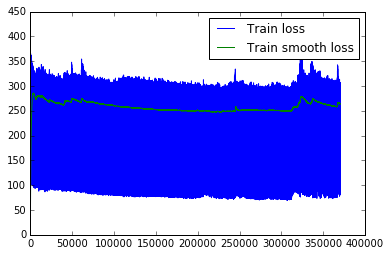

In [4]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 10000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 10 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = LSTM(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()